<a href="https://colab.research.google.com/github/jyanivaddi/ERA_V1/blob/master/session_10/s10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone "https://github.com/jyanivaddi/ERA_V1.git"
!git pull
!pip install torchinfo
!pip install prettytable
!pip install torch_lr_finder

fatal: destination path 'ERA_V1' already exists and is not an empty directory.
fatal: not a git repository (or any of the parent directories): .git


Add all the imports

In [2]:
from __future__ import print_function
import sys
sys.path.append("ERA_V1/session_10")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import albumentations as A
import albumentations.augmentations as AA
from albumentations.pytorch import ToTensorV2
from utils import preview_images, plot_statistics, show_incorrect_predictions, get_incorrect_predictions, print_train_log
from custom_resnet.custom_resnet import CustomResnet, model_summary
from custom_resnet.data_loader import load_cifar10_data
from custom_resnet.training import training_loop
from custom_resnet.inference import model_test
from custom_resnet.optimizer import Optimization, find_best_lr


/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Allocate GPU

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
resnet_model = CustomResnet(base_channels=3,num_classes=10).to(device)
model_summary(resnet_model, input_size=(3,32,32))



Layer (type:depth-idx)                   Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds
CustomResnet                             --                        [1, 3, 32, 32]            [1, 10]                   --                        --
├─Sequential: 1-1                        --                        [1, 3, 32, 32]            [1, 64, 32, 32]           --                        --
│    └─Conv2d: 2-1                       [3, 3]                    [1, 3, 32, 32]            [1, 64, 32, 32]           1,728                     1,769,472
│    └─BatchNorm2d: 2-2                  --                        [1, 64, 32, 32]           [1, 64, 32, 32]           128                       128
│    └─ReLU: 2-3                         --                        [1, 64, 32, 32]           [1, 64, 32, 32]           --                        --
│    └─Dropout: 2-4                      --                        [1, 64, 32, 32]           [1, 

/content/ERA_V1/session_10/custom_resnet/custom_resnet.py:161: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Define Transforms

In [4]:
train_transforms = A.Compose(
    [
        A.augmentations.crops.transforms.CropAndPad(-4, p=0.5),
        A.HorizontalFlip(p=0.5),
        AA.dropout.coarse_dropout.CoarseDropout(max_holes = 1, max_height=8,
                                                max_width=8, min_holes = 1,
                                                min_height=8, min_width=8,
                                                fill_value=(0.491, 0.482, 0.447),
                                                mask_fill_value = None),

        A.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262)),
        ToTensorV2(),
    ]
)
test_transforms = A.Compose([
    A.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262)),
    ToTensorV2(),
])

Define train and test loaders

In [5]:
torch.manual_seed(1)
batch_size = 512
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
train_loader, test_loader, class_names = load_cifar10_data(train_transforms, test_transforms, batch_size, **kwargs)

Files already downloaded and verified
Files already downloaded and verified


Show sample Images from the dataset

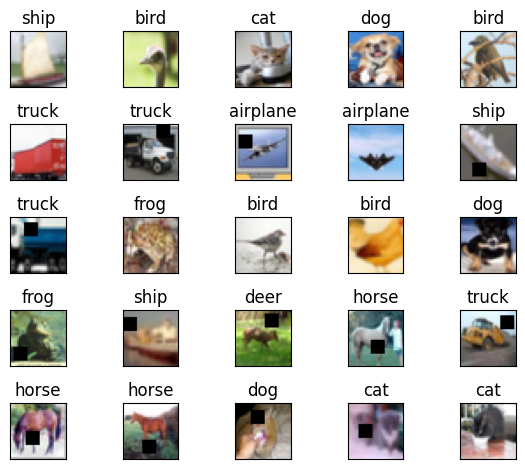

In [6]:
preview_images(train_loader,class_names, num_rows = 5, num_cols = 5)

Train model using Batch Normalization

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.87E-02


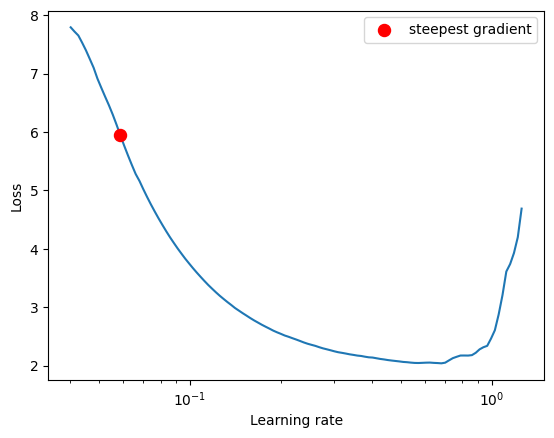

In [7]:
drop_out = 0.02
num_epochs=24
resnet_model = CustomResnet(base_channels=3, num_classes=10,drop_out_probability=drop_out).to(device)
criterion = nn.CrossEntropyLoss(reduction='mean')
optim_obj = Optimization(resnet_model, device, train_loader, criterion, num_epochs)
lr_history = find_best_lr(resnet_model, train_loader, optim_obj.optimizer, criterion, device)


In [8]:
from torch.optim.lr_scheduler import OneCycleLR
#optim_obj.define_scheduler(max_lr=4.93E-2)
train_losses = []
test_losses = []
train_acc = []
test_acc = []
lr_values = []
def define_scheduler(max_lr):
    scheduler = OneCycleLR(
        optim_obj.optimizer,
        max_lr = max_lr,
        steps_per_epoch=len(optim_obj.train_loader),
        epochs = num_epochs,
        pct_start = 5./num_epochs,
        div_factor=100,
        three_phase=False,
        final_div_factor= 1000,
        anneal_strategy='linear',
        verbose=False
        )
    return scheduler

max_lr = 5.87e-2
optim_obj.scheduler = define_scheduler(max_lr)

for epoch in range(1,num_epochs+1):
    lr_values.append(optim_obj.scheduler.get_lr())
    print(f"epoch: {epoch}\t learning rate: {optim_obj.scheduler.get_last_lr()[0]}")
    this_train_loss = training_loop(resnet_model, device, train_loader, optim_obj.optimizer, optim_obj.scheduler, criterion, train_acc, train_losses)
    this_loss = model_test(resnet_model, device, test_loader, criterion, test_acc, test_losses)
    #optim_obj.scheduler.step()



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:1699: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


epoch: 1	 learning rate: 0.0005870000000000001


loss=1.3886826038360596 batch_id=97 Accuracy = 38.68: 100%|██████████| 98/98 [00:29<00:00,  3.36it/s]



Test set: Average loss: 0.0033, Accuracy: 4336/10000 (43.36%)

epoch: 2	 learning rate: 0.01223336809815951


loss=1.1135272979736328 batch_id=97 Accuracy = 53.57: 100%|██████████| 98/98 [00:28<00:00,  3.48it/s]



Test set: Average loss: 0.0024, Accuracy: 5912/10000 (59.12%)

epoch: 3	 learning rate: 0.02387973619631902


loss=1.0488864183425903 batch_id=97 Accuracy = 64.03: 100%|██████████| 98/98 [00:27<00:00,  3.58it/s]



Test set: Average loss: 0.0020, Accuracy: 6699/10000 (66.99%)

epoch: 4	 learning rate: 0.03552610429447853


loss=0.9055818915367126 batch_id=97 Accuracy = 68.64: 100%|██████████| 98/98 [00:28<00:00,  3.50it/s]



Test set: Average loss: 0.0028, Accuracy: 5558/10000 (55.58%)

epoch: 5	 learning rate: 0.04717247239263803


loss=1.0012743473052979 batch_id=97 Accuracy = 67.97: 100%|██████████| 98/98 [00:28<00:00,  3.49it/s]



Test set: Average loss: 0.0037, Accuracy: 4792/10000 (47.92%)

epoch: 6	 learning rate: 0.0586684750735768


loss=0.8738505840301514 batch_id=97 Accuracy = 68.38: 100%|██████████| 98/98 [00:27<00:00,  3.60it/s]



Test set: Average loss: 0.0021, Accuracy: 6275/10000 (62.75%)

epoch: 7	 learning rate: 0.055579032284103116


loss=0.9661667346954346 batch_id=97 Accuracy = 69.01: 100%|██████████| 98/98 [00:26<00:00,  3.63it/s]



Test set: Average loss: 0.0018, Accuracy: 6928/10000 (69.28%)

epoch: 8	 learning rate: 0.05248958949462943


loss=0.8894268870353699 batch_id=97 Accuracy = 70.51: 100%|██████████| 98/98 [00:27<00:00,  3.61it/s]



Test set: Average loss: 0.0018, Accuracy: 6837/10000 (68.37%)

epoch: 9	 learning rate: 0.049400146705155745


loss=0.8490155339241028 batch_id=97 Accuracy = 70.27: 100%|██████████| 98/98 [00:26<00:00,  3.65it/s]



Test set: Average loss: 0.0023, Accuracy: 6244/10000 (62.44%)

epoch: 10	 learning rate: 0.04631070391568207


loss=0.7916417717933655 batch_id=97 Accuracy = 70.98: 100%|██████████| 98/98 [00:26<00:00,  3.68it/s]



Test set: Average loss: 0.0019, Accuracy: 6599/10000 (65.99%)

epoch: 11	 learning rate: 0.04322126112620838


loss=0.8839755058288574 batch_id=97 Accuracy = 71.97: 100%|██████████| 98/98 [00:26<00:00,  3.64it/s]



Test set: Average loss: 0.0023, Accuracy: 5915/10000 (59.15%)

epoch: 12	 learning rate: 0.040131818336734695


loss=0.7222102284431458 batch_id=97 Accuracy = 72.34: 100%|██████████| 98/98 [00:26<00:00,  3.70it/s]



Test set: Average loss: 0.0022, Accuracy: 6340/10000 (63.40%)

epoch: 13	 learning rate: 0.03704237554726101


loss=0.7293955683708191 batch_id=97 Accuracy = 72.32: 100%|██████████| 98/98 [00:26<00:00,  3.68it/s]



Test set: Average loss: 0.0020, Accuracy: 6439/10000 (64.39%)

epoch: 14	 learning rate: 0.033952932757787324


loss=0.7108417749404907 batch_id=97 Accuracy = 73.42: 100%|██████████| 98/98 [00:26<00:00,  3.71it/s]



Test set: Average loss: 0.0015, Accuracy: 7357/10000 (73.57%)

epoch: 15	 learning rate: 0.030863489968313642


loss=0.7067943811416626 batch_id=97 Accuracy = 73.98: 100%|██████████| 98/98 [00:26<00:00,  3.71it/s]



Test set: Average loss: 0.0019, Accuracy: 6526/10000 (65.26%)

epoch: 16	 learning rate: 0.02777404717883996


loss=0.8341825604438782 batch_id=97 Accuracy = 75.22: 100%|██████████| 98/98 [00:26<00:00,  3.71it/s]



Test set: Average loss: 0.0018, Accuracy: 6992/10000 (69.92%)

epoch: 17	 learning rate: 0.02468460438936628


loss=0.721724808216095 batch_id=97 Accuracy = 75.94: 100%|██████████| 98/98 [00:26<00:00,  3.69it/s]



Test set: Average loss: 0.0013, Accuracy: 7748/10000 (77.48%)

epoch: 18	 learning rate: 0.02159516159989259


loss=0.710075855255127 batch_id=97 Accuracy = 76.99: 100%|██████████| 98/98 [00:26<00:00,  3.72it/s]



Test set: Average loss: 0.0013, Accuracy: 7834/10000 (78.34%)

epoch: 19	 learning rate: 0.018505718810418903


loss=0.5400694012641907 batch_id=97 Accuracy = 78.10: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]



Test set: Average loss: 0.0013, Accuracy: 7814/10000 (78.14%)

epoch: 20	 learning rate: 0.015416276020945224


loss=0.6281258463859558 batch_id=97 Accuracy = 79.28: 100%|██████████| 98/98 [00:26<00:00,  3.73it/s]



Test set: Average loss: 0.0012, Accuracy: 7889/10000 (78.89%)

epoch: 21	 learning rate: 0.012326833231471539


loss=0.5177245736122131 batch_id=97 Accuracy = 80.90: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]



Test set: Average loss: 0.0010, Accuracy: 8242/10000 (82.42%)

epoch: 22	 learning rate: 0.009237390441997853


loss=0.5176979899406433 batch_id=97 Accuracy = 82.42: 100%|██████████| 98/98 [00:26<00:00,  3.70it/s]



Test set: Average loss: 0.0009, Accuracy: 8392/10000 (83.92%)

epoch: 23	 learning rate: 0.0061479476525241675


loss=0.4306340515613556 batch_id=97 Accuracy = 84.67: 100%|██████████| 98/98 [00:26<00:00,  3.75it/s]



Test set: Average loss: 0.0008, Accuracy: 8573/10000 (85.73%)

epoch: 24	 learning rate: 0.003058504863050489


loss=0.5064387321472168 batch_id=97 Accuracy = 87.10: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]



Test set: Average loss: 0.0007, Accuracy: 8754/10000 (87.54%)



Plot LR values

In [9]:
import matplotlib.pyplot as plt
def plot_lr_values2(lr_list):
    num_epochs = len(lr_list)
    plt.figure()
    plt.plot(range(1,num_epochs+1),lr_list)
    plt.xlabel('Epoch #')
    plt.ylabel("Learning Rate")
    #plt.yscale('log')
    plt.show()

def plot_lr_values(scheduler, num_epochs, num_batches):
    lrs = []
    steps = []
    for epoch in range(num_epochs):
        for batch in range(num_batches):
            scheduler.step()
            lrs.append(scheduler.get_last_lr()[0])
            steps.append(epoch * num_batches + batch)

    plt.figure()
    plt.legend()
    plt.plot(steps, lrs, label='OneCycle')
    plt.show()

def plot_losses(train_losses, test_losses):
    fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    epochs = range(1,len(train_losses)+1)
    axs[0].plot(epochs, train_losses)
    axs[0].set_title("Train")
    axs[1].plot(epochs, test_losses)
    axs[1].set_title("Test")

def plot_accuracy(train_acc, test_acc, target_test_acc = 90.):
    epochs = range(1,len(train_acc)+1)
    plt.figure()
    plt.plot(epochs, train_acc, epochs, test_acc)
    plt.axhline(target_test_acc, color='r')
    plt.legend(('Train','Test'),loc='best')
    plt.title("Accuracy")


Plot results for Batch Norm experiment

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


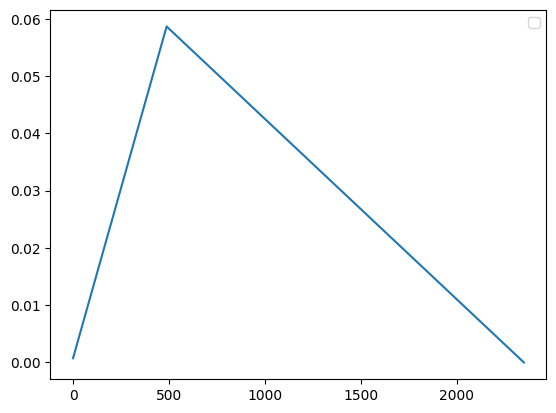

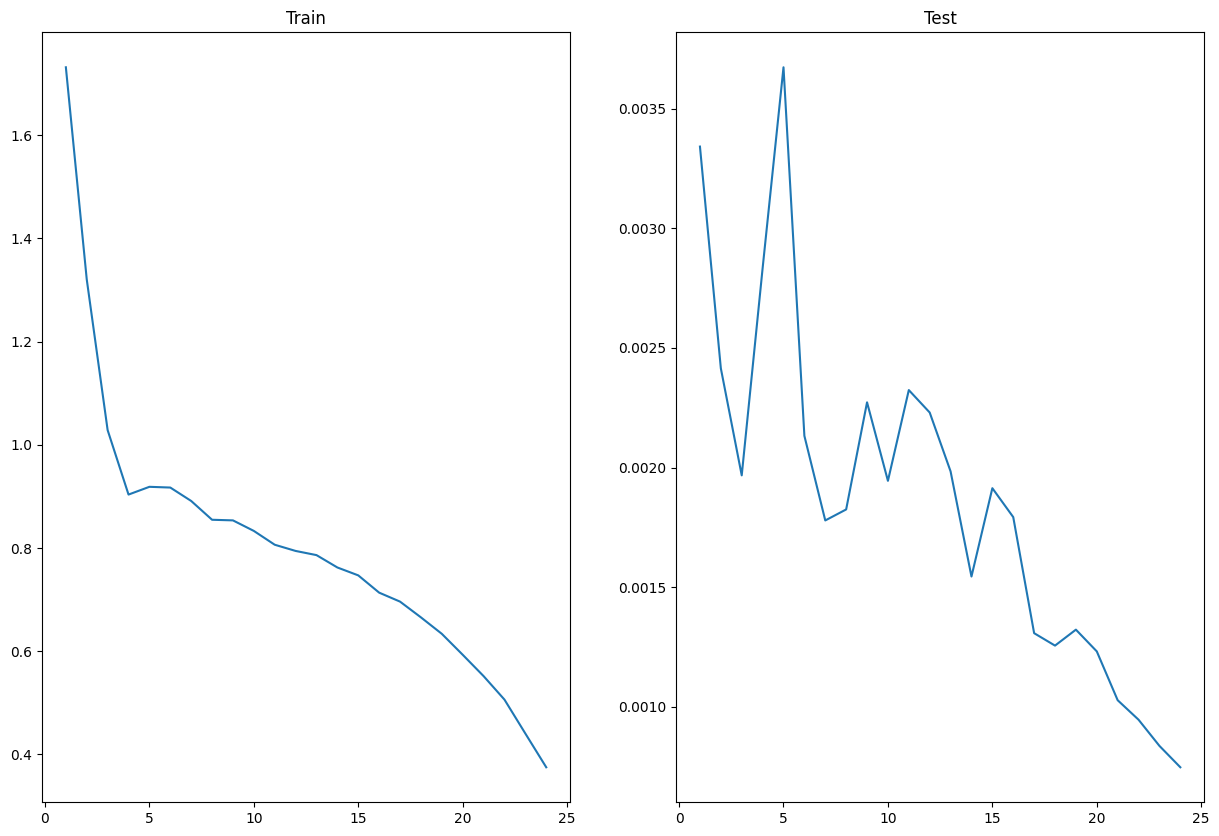

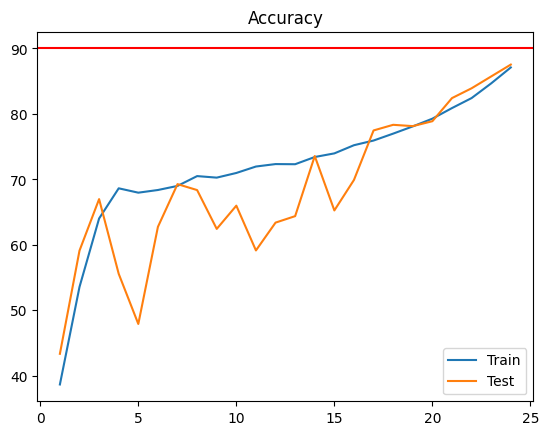

In [10]:
this_scheduler = OneCycleLR(
        optim_obj.optimizer,
        max_lr = max_lr,
        steps_per_epoch=len(optim_obj.train_loader),
        epochs = num_epochs,
        pct_start = 5./num_epochs,
        div_factor=200,
        three_phase=False,
        #final_div_factor=1000,
        anneal_strategy='linear',
        verbose=False
        )
plot_lr_values(this_scheduler, num_epochs, len(train_loader))
plot_losses(train_losses, test_losses)
plot_accuracy(train_acc, test_acc, target_test_acc=90.)


Print Training Log

In [11]:
print_train_log(train_acc, test_acc, train_losses, test_losses)

+-------+---------------------+-----------------------+----------------+--------------+
| Epoch |      Train loss     |        Val loss       | Train Accuracy | Val Accuracy |
+-------+---------------------+-----------------------+----------------+--------------+
|   1   |  1.7314375261871182 |  0.003341380798816681 |     38.676     |    43.36     |
|   2   |  1.3203410931995936 | 0.0024147086501121523 |     53.574     |    59.12     |
|   3   |  1.0283685466464685 |  0.001967564523220062 |     64.03      |    66.99     |
|   4   |  0.9034968797041445 |  0.002832947027683258 |     68.64      |    55.58     |
|   5   |  0.9185239739564001 | 0.0036727670788764956 |     67.974     |    47.92     |
|   6   |  0.9171021148866537 |  0.002132621616125107 |     68.382     |    62.75     |
|   7   |  0.8911082264111967 | 0.0017791045129299163 |     69.006     |    69.28     |
|   8   |  0.8546842391393623 | 0.0018250778675079347 |     70.506     |    68.37     |
|   9   |  0.8534814897848635 | 